### PANOPTES State Machine

This notebook gives an example run through of the PANOPTES State Machine (PSM). Below we manually walk through the various states so we can explain what happens along the way. When PANOPTES is actually running these steps will automatically transition.

In [1]:
# Load the PANOPTES module dir
from IPython.display import Image
import sys
sys.path.append('../')

from panoptes.core import Panoptes

In [2]:
Panoptes.load_state_table()

{'initial': 'sleeping',
 'states': ['parked',
  'parking',
  'sleeping',
  'ready',
  'scheduling',
  'slewing',
  'tracking',
  'observing',
  'analyzing'],
 'transitions': [{'dest': 'sleeping', 'source': 'parked', 'trigger': 'sleep'},
  {'dest': 'parking',
   'source': ['ready',
    'scheduling',
    'slewing',
    'tracking',
    'observing',
    'analyzing'],
   'trigger': 'park'},
  {'dest': 'parked', 'source': 'parking', 'trigger': 'set_park'},
  {'dest': 'ready', 'source': 'parked', 'trigger': 'get_ready'},
  {'conditions': 'initialize',
   'dest': 'ready',
   'source': 'sleeping',
   'trigger': 'get_ready'},
  {'dest': 'scheduling', 'source': 'ready', 'trigger': 'schedule'},
  {'dest': 'scheduling', 'source': 'analyzing', 'trigger': 'schedule'},
  {'dest': 'slewing', 'source': 'scheduling', 'trigger': 'slew_to_target'},
  {'conditions': 'mount_is_tracking',
   'dest': 'tracking',
   'source': 'slewing',
   'trigger': 'track'},
  {'conditions': 'mount_is_tracking',
   'dest': 'o

#### Create

The first step is to create an instance of our `Panoptes` class. Here we instantiate a simulator version. Possible values for the simulator include: `all`, `weather`, `mount`, `camera`

In [3]:
pan = Panoptes(simulator=['mount', 'weather'])

2016-01-16 17:49:10 europa panoptes[4368] INFO ********************************************************************************
2016-01-16 17:49:10 europa panoptes[4368] INFO Initializing PANOPTES unit
2016-01-16 17:49:10 europa panoptes[4368] INFO Welcome PAN001!
2016-01-16 17:49:10 europa panoptes[4368] INFO Loading state table
2016-01-16 17:49:10 europa panoptes[4368] INFO 	 messaging system
2016-01-16 17:49:10 europa panoptes[4368] INFO 	 weather station
2016-01-16 17:49:10 europa panoptes[4368] INFO 	 observatory
2016-01-16 17:49:10 europa panoptes.observatory[4368] INFO 	Initializing observatory
2016-01-16 17:49:10 europa panoptes.observatory[4368] INFO 		 Setting up location
2016-01-16 17:49:10 europa panoptes.observatory[4368] INFO 		 Setting up mount
2016-01-16 17:49:10 europa panoptes.mount.simulator[4368] INFO 		Using simulator mount
2016-01-16 17:49:10 europa panoptes.observatory[4368] INFO 		 Setting up cameras
2016-01-16 17:49:10 europa panoptes.observatory[4368] INFO 		 

Above you see the log output from the unit. Here `PAN001` is the name of the unit. The messages that start with `PAN001 says:` are intended to be user-friendly messages. Full debug log output is written to `/var/panoptes/log/panoptes.log`.

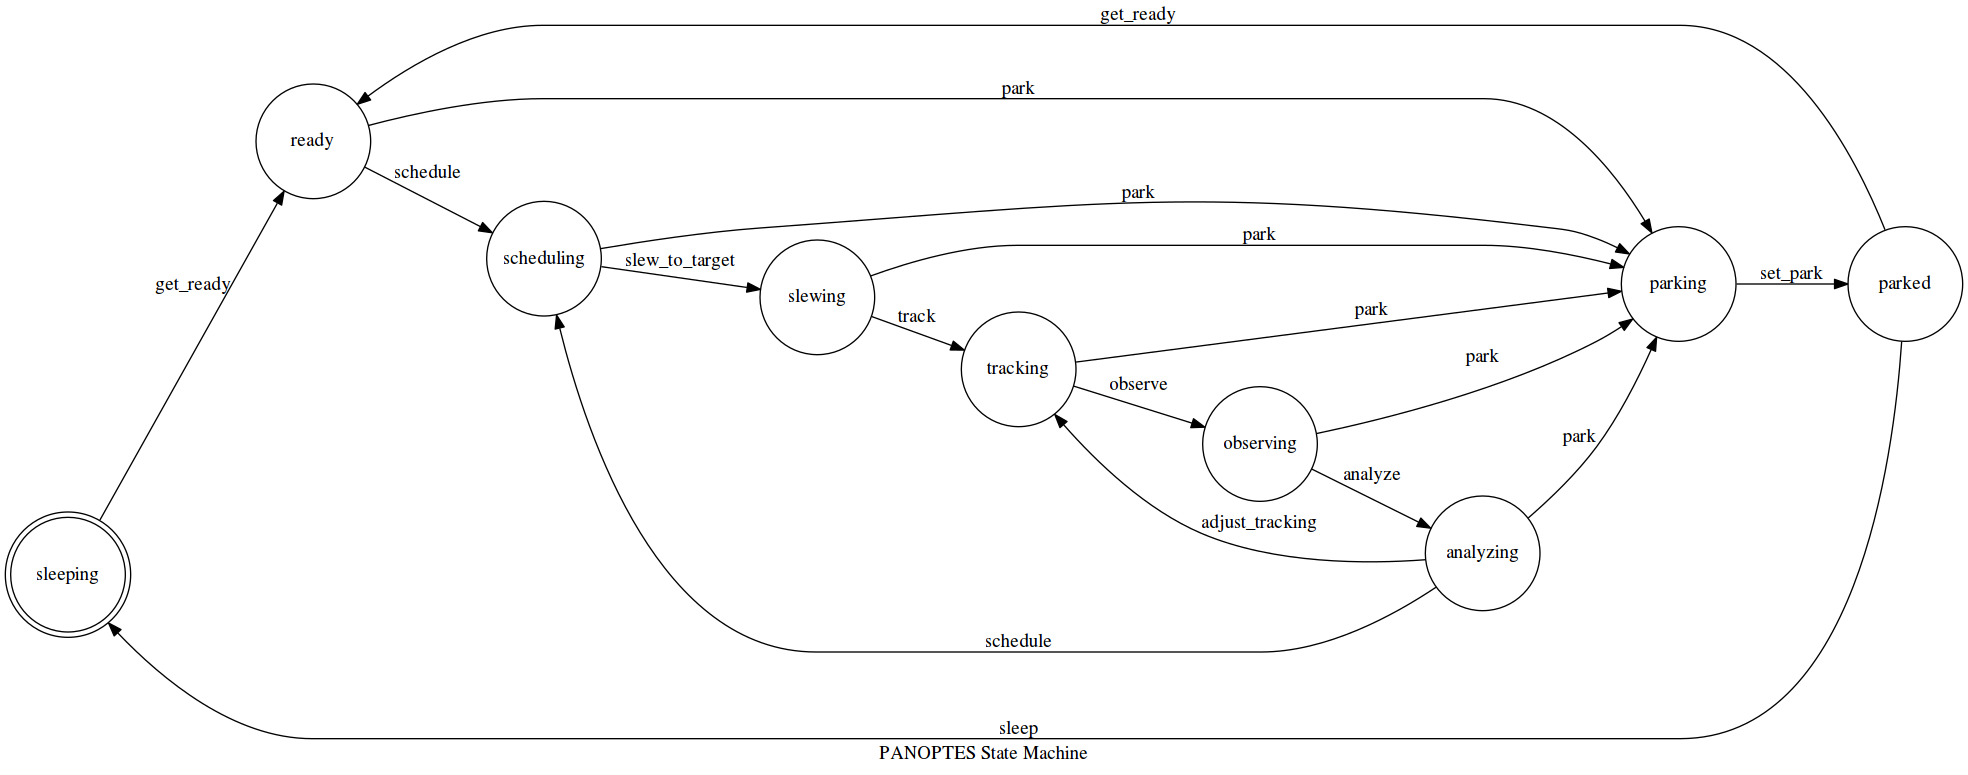

In [4]:
pan.get_graph(title="PANOPTES State Machine").draw('state.png', prog='dot')
Image('state.png')

#### Get Ready!

Our unit is now up and running, sitting in the default state of `parked`. The first thing we want to do is get our unit in the `ready` __state__. To do this, we call `get_ready()`, which is the __transition__.

In [5]:
# Call the transition to go from parked->ready
pan.get_ready()

2016-01-16 17:49:11 europa panoptes[4368] INFO PAN001 says: Initializing the system! Woohoo!
2016-01-16 17:49:30 europa panoptes[4368] INFO PAN001 says: Up and ready to go!


True

We can double check which state we are currently in with:

In [6]:
pan.state

'ready'

#### Schedule

Our unit is now initialized and ready to start processing for the night. The first thing to do is send the unit to the `scheduling` state via the `schedule()` transition:

In [7]:
pan.schedule()

2016-01-16 17:49:31 europa panoptes[4368] INFO PAN001 says: Ok, I'm finding something good to look at...
2016-01-16 17:49:41 europa panoptes.scheduler.core[4368] INFO Evaluating candidate targets
2016-01-16 17:49:42 europa panoptes.scheduler.core[4368] INFO Chosen target is HAT-P-16 with priority 115
2016-01-16 17:49:42 europa panoptes[4368] INFO <Target "HAT-P-16" at SkyCoord (ICRS): (ra, dec) in deg (9.57317333, 42.46312472)>
2016-01-16 17:49:42 europa panoptes[4368] INFO PAN001 says: Got it! I'm going to check out: HAT-P-16


True

The output above indicates that we successfully found a target to look at. Let's double-check that we are now in the `scheduling` state still and then let's transition to `slewing` via the transition `slew_to_target()`:

In [8]:
print(pan.state)
pan.slew_to_target()

2016-01-16 17:49:42 europa panoptes[4368] INFO PAN001 says: I'm slewing over to the coordinates to track the target.


scheduling


True

Now we want to start tracking the target so we transition to the `tracking` state:

In [9]:
pan.track()

False

But we notice that we got a `False` return value, meaning the transition didn't occur. This is because if we look at the transition event we can see it has some conditions associated with it:

In [10]:
for condition in pan.events['track'].transitions['slewing'][0].conditions:
    print(condition.func)

check_safety
mount_is_tracking


Namely, we want to see if the `mount_is_tracking`, which it is not. In a normal run, the event loop for the state machine will handle these automatic transitions, so here we manually set the mount to tracking via a helper method (`stop_slew`) available to the simulator mount and then call `track` again:

___Note___: _Never do this for real, this is handled by the event loop. Notice the private variable._

In [11]:
pan.observatory.mount.stop_slew()
pan.track()

2016-01-16 17:49:42 europa panoptes[4368] INFO PAN001 says: I'm now tracking the target.


True

In [12]:
pan.state

'tracking'

In [13]:
pan.observe()

2016-01-16 17:49:42 europa panoptes[4368] INFO PAN001 says: I'm finding exoplanets!


True

In [14]:
pan.analyze()

2016-01-16 17:49:43 europa panoptes[4368] INFO PAN001 says: Analyzing image...
2016-01-16 17:49:43 europa panoptes.scheduler.observation[4368] WARNING No images to process
2016-01-16 17:49:43 europa panoptes[4368] WARNING Problem analyzing: None


True

In [15]:
pan.park()

2016-01-16 17:49:43 europa panoptes[4368] INFO PAN001 says: I'm takin' it on home and then parking.
2016-01-16 17:49:43 europa panoptes.mount.simulator[4368] INFO Going home then parking
2016-01-16 17:49:43 europa panoptes[4368] INFO PAN001 says: Saving any observations


True

In [16]:
pan.set_park()

2016-01-16 17:49:43 europa panoptes[4368] INFO PAN001 says: I'm parked now. Phew.


True

In [17]:
pan.sleep()

2016-01-16 17:49:43 europa panoptes[4368] INFO PAN001 says: ZZzzzz...


True